In [1]:
import pandas as pd
import numpy as np
import joblib

In [2]:
loaded_model = joblib.load('csvs\modelo_polinomial_multicase.pkl')

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\renan\AppData\Local\Temp\ipykernel_8928\194325705.py:1: SyntaxWarning: invalid escape sequence '\m'
  loaded_model = joblib.load('csvs\modelo_polinomial_multicase.pkl')


In [6]:
df_test = pd.read_csv('csvs\cs-test.csv', index_col=0)
df_test.fillna({'MonthlyIncome': df_test['MonthlyIncome'].median(), 'NumberOfDependents': df_test['NumberOfDependents'].median()}, inplace=True)
df_test.drop(columns=['SeriousDlqin2yrs'], inplace=True)
# Carregar o dataset de teste
df_test["IncomePerDependent"] = df_test["MonthlyIncome"] / (df_test["NumberOfDependents"] + 1)
df_test["DebtPerLoan"] = df_test["DebtRatio"] / (df_test["NumberOfOpenCreditLinesAndLoans"] + 1)
df_test["Pagamentos_atrasados_Total"] = df_test['NumberOfTime30-59DaysPastDueNotWorse'] + df_test['NumberOfTime60-89DaysPastDueNotWorse'] + df_test['NumberOfTimes90DaysLate']
# Garantir que as mesmas features existam 
df_test['DelinquencyLevel'] = 0

df_test.loc[df_test['NumberOfTime30-59DaysPastDueNotWorse'] > 0, 'DelinquencyLevel'] = 1
df_test.loc[df_test['NumberOfTime60-89DaysPastDueNotWorse'] > 0, 'DelinquencyLevel'] = 2
df_test.loc[df_test['NumberOfTimes90DaysLate'] > 0, 'DelinquencyLevel'] = 3

# definir todos os valores de DelinquencyLevel como NaN
df_test['DelinquencyLevel'] = np.nan
# se existir a coluna em X_new (por segurança), atualizar também
df_test['MonthlyIncome_log'] = np.log1p(df_test['MonthlyIncome'].clip(lower=0))
df_test['DebtRatio_clipped'] = df_test['DebtRatio'].clip(upper=10)
df_test['DebtPerLoan_clipped'] = df_test['DebtPerLoan'].clip(upper=100)

cols_to_use = [
    'RevolvingUtilizationOfUnsecuredLines', 'age',
    'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
    'NumberOfDependents', 'IncomePerDependent',
    'Pagamentos_atrasados_Total', 'MonthlyIncome_log',
    'DebtRatio_clipped', 'DebtPerLoan_clipped'
]
X_new = df_test[cols_to_use]
if 'DelinquencyLevel' in X_new.columns:
    X_new['DelinquencyLevel'] = np.nan



y_pred = loaded_model.predict(X_new)

# Armazenar no DataFrame
df_test['DelinquencyLevel_pred'] = y_pred

# (opcional) salvar resultado
df_test[['DelinquencyLevel_pred']].to_csv('csvs/previsoes_multiclasse.csv')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\renan\AppData\Local\Temp\ipykernel_8928\3380677473.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_test = pd.read_csv('csvs\cs-test.csv', index_col=0)


In [7]:
df_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerDependent,DebtPerLoan,Pagamentos_atrasados_Total,DelinquencyLevel,MonthlyIncome_log,DebtRatio_clipped,DebtPerLoan_clipped,DelinquencyLevel_pred
1,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,5700.000000,0.035503,0,NaN,8.648397,0.177513,0.035503,0
2,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,3047.000000,0.032952,0,NaN,9.120634,0.527237,0.032952,0
3,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,1694.333333,0.052896,0,NaN,8.533854,0.687648,0.052896,0
4,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,3200.000000,0.115745,1,NaN,8.071219,0.925961,0.115745,1
5,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,1932.500000,0.003983,0,NaN,8.259976,0.019917,0.003983,0


In [8]:
print(df_test['DelinquencyLevel_pred'].value_counts(normalize=True))

DelinquencyLevel_pred
0    0.635636
3    0.238732
1    0.090726
2    0.034905
Name: proportion, dtype: float64


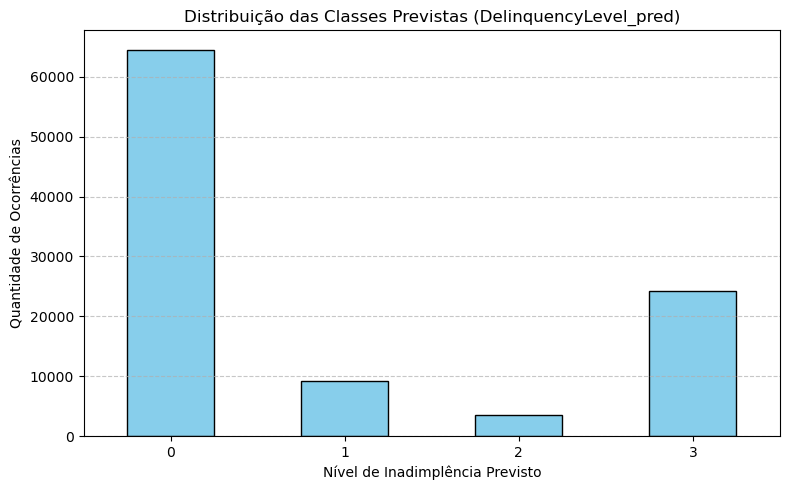

In [9]:
import matplotlib.pyplot as plt

# Gerar gráfico de barras da distribuição das classes previstas
plt.figure(figsize=(8, 5))
df_test['DelinquencyLevel_pred'].value_counts().sort_index().plot(
    kind='bar', edgecolor='black', color='skyblue'
)
plt.title('Distribuição das Classes Previstas (DelinquencyLevel_pred)')
plt.xlabel('Nível de Inadimplência Previsto')
plt.ylabel('Quantidade de Ocorrências')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
